En este NoteBook se encuentra desarrolado el ETL (Extraction, Transformation and Load, en español, Extraccion, Transformacion y Carga) con los Datasets brindados por Henry 'movies_dataset' y 'credits'.
Posteriormente tambien desarrollo el EDA (Exploratory Data Analysis) del dataset que se fue desarrollando con el proceso de ETL ya limpiado y unido para un mejor tratamiento de los datos.  

**ETL Movies**

In [129]:
import pandas as pd
import ast  # Para convertir el string del diccionario en un diccionario real
import numpy as np
from pandas import json_normalize
import random

import matplotlib.pyplot as plt
import seaborn as sns

Levantamos data set brindado por Henry llamado 'movies_dataset.csv'. El archivo de Movies no se encuentra en el Repo por su tamaño, por favor en caso de necesitarlo encontrarlo en el siguiente link https://drive.google.com/file/d/11PW-n4obMTgK-YZ9VD3cVJwiabr7hY1c/view?usp=share_link


In [130]:
#Leemos el archivo
data = pd.read_csv('/Users/julianscarpeccio/Desktop/Data Science HENRY/LABS/PI MLOps/movies_dataset.csv')

/var/folders/rl/4_3j3kb90d74wbdrz3mdbvn00000gn/T/ipykernel_82514/3564248637.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/julianscarpeccio/Desktop/Data Science HENRY/LABS/PI MLOps/movies_dataset.csv')


In [131]:
#Convertimos en Data Frame
df = pd.DataFrame(data)

In [132]:
df.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [133]:
# Funcion para desanidar columnas que son diccionarios dentro del Data Frame
def extraer_collection_names(collection):
    if pd.isnull(collection):
        return np.nan
    else:
        try:
            collection_dict = ast.literal_eval(collection)
            if isinstance(collection_dict, dict) and 'name' in collection_dict:
                return [collection_dict['name']]
            elif isinstance(collection_dict, list):
                names = [item['name'] for item in collection_dict if isinstance(item, dict) and 'name' in item]
                return names
            else:
                return np.nan
        except (ValueError, TypeError):
            return np.nan

In [134]:
# Luego aplicamos la función a 'belongs_to_collection'
df['belongs_to_collection'] = df['belongs_to_collection'].apply(extraer_collection_names)
# Luego aplicamos la función a 'genres'
df['genres'] = df['genres'].apply(extraer_collection_names)
# Luego aplicamos la función a 'production_companies'
df['production_companies'] = df['production_companies'].apply(extraer_collection_names)
# Luego aplicamos la función a 'production_countries'
df['production_countries'] = df['production_countries'].apply(extraer_collection_names)
# Luego aplicamos la función a 'spoken_languages'
df['spoken_languages'] = df['spoken_languages'].apply(extraer_collection_names)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [136]:
#llenamos valores con 0 como lo piden las consignas
df['revenue'].fillna(0, inplace=True)
df['budget'].fillna(0, inplace=True)

#eliminamos las filas con valores nulos en la columna 'release date'
df.dropna(subset=['release_date'], inplace=True)
#reemplazamos valores no convertibles con NaN, con la opción errors='coerce' se utiliza para indicar que si un valor no puede convertirse a fecha, se reemplace con NaN. 
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')
#eliminamos filas con valores no convertibles
df.dropna(subset=['release_date'], inplace=True)

#creamos columna 'release_year'
df['release_year'] = df['release_date'].dt.year

#BORRAMOS DATOS QUE NO SIRVE DE LA COLUMNA BUDGET
#convierte la columna a valores numéricos y convierte los no numéricos en NaN
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
#Elimina las filas que contienen NaN en la columna "budget"
df.dropna(subset=['budget'], inplace=True)
#Crear la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo estas dos últimas revenue / budget, 
#cuando no hay datos disponibles para calcularlo, toma el valor 0.
df['return'] = df.apply(lambda row: row['revenue'] / row['budget'] if row['revenue'] != 0 and row['budget'] != 0 else 0, axis=1)


In [137]:
# Eliminamos columnas que no vamos a utilizar
# Lista de columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage']
# Eliminar las columnas del DataFrame
df = df.drop(columns=columnas_a_eliminar)

In [138]:
#Extraemos los nombres de 'belongs_to_collection' para extraerlos de la lista

def extract_name_from_list(lst):
    if isinstance(lst, list) and len(lst) > 0:
        return lst[0]  # Extraer el primer elemento de la lista
    else:
        return None

# Aplicar la función a la columna "collection" para extraer los nombres
df['belongs_to_collection'] = df['belongs_to_collection'].apply(extract_name_from_list)

In [139]:
#vista previa del data frame
df

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,release_year,return
0,Toy Story Collection,30000000,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,7.7,5415.0,1995,12.451801
1,None,65000000,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995,4.043035
2,Grumpy Old Men Collection,0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995,0.000000
3,None,16000000,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995,5.090760
4,Father of the Bride Collection,0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45460,None,0,"[Drama, Action, Romance]",30840,en,"Yet another version of the classic epic, with ...",5.683753,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",1991-05-13,0.0,104.0,[English],Released,NaN,Robin Hood,5.7,26.0,1991,0.000000
45462,None,0,[Drama],111109,tl,An artist struggles to finish his work while a...,0.178241,[Sine Olivia],[Philippines],2011-11-17,0.0,360.0,[],Released,NaN,Century of Birthing,9.0,3.0,2011,0.000000
45463,None,0,"[Action, Drama, Thriller]",67758,en,"When one of her hits goes wrong, a professiona...",0.903007,[American World Pictures],[United States of America],2003-08-01,0.0,90.0,[English],Released,A deadly game of wits.,Betrayal,3.8,6.0,2003,0.000000
45464,None,0,[],227506,en,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,0.0,0.0,1917,0.000000


ETL Credits

In [140]:
#levantamos el otro data set brindado por Henry llamado 'credits.csv' y el creado anteriormente el cual llamé 'mi_dm'
# El archivo de Credits no se encuentra en el Repo por su tamaño, por favor en caso de necesitarlo encontrarlo en el siguiente link https://drive.google.com/file/d/1HxSWoxncj9Waqn2k5BJdeRaHLuZ4-MoE/view?usp=share_link

credits = pd.read_csv('/Users/julianscarpeccio/Desktop/Data Science HENRY/LABS/PI MLOps/credits.csv')
credits = pd.DataFrame(credits)

In [141]:
#Cambaimos el tipo de dato para la columna 'id' en ambos data frames
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')
#unimos los data frames tomando el 'id' de la pelicula, columna que se encuentra en ambos.
df = df.merge(credits, on='id')

In [142]:
#Aplicamos la función ast.literal_eval a cada elemento de la columna "cast" y "crew" para convertir 
#una cadena que contiene una lista o diccionario en una lista de Python real facilitando el acceso y la manipulación 
#de los datos contenidos en esas columnas.

df['cast'] = df['cast'].apply(ast.literal_eval)
df['crew'] = df['crew'].apply(ast.literal_eval)

In [143]:
#La función itera a través de la lista de diccionarios y verifica si el valor asociado a la clave 'job' 
#en el diccionario actual es igual a 'Director'. Si encuentra un diccionario en el que el valor de 'job' sea 'Director', 
#la función devuelve el valor asociado a la clave 'name' en ese diccionario, que sería el nombre del director.

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [144]:
#aplicamos la funcion anterior a la columna 'crew'

df['director'] = df['crew'].apply(get_director)

In [145]:
#Creamos una funcion que extraiga los nombres de los actores de la columna 'cast'.

df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [146]:
#eliminamos la columna crew ya desanidada.
df.drop(columns='crew', inplace=True)

In [147]:
#Vamos a eliminar las columans que no nos sirven para las Consultas de la API y achicar el tamano del archivo
columnas_a_eliminar = ['vote_count', 'release_date','original_language', 'status', 'genres', 'overview', 'tagline', 'cast', 'vote_average', 'popularity' ]

df_consultas = df.drop(columns= columnas_a_eliminar)

In [148]:
df_consultas

,belongs_to_collection,budget,id,production_companies,production_countries,revenue,runtime,spoken_languages,title,release_year,return,director
0,Toy Story Collection,30000000,862,[Pixar Animation Studios],[United States of America],373554033.0,81.0,[English],Toy Story,1995,12.451801,John Lasseter
1,None,65000000,8844,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],262797249.0,104.0,"[English, Français]",Jumanji,1995,4.043035,Joe Johnston
2,Grumpy Old Men Collection,0,15602,"[Warner Bros., Lancaster Gate]",[United States of America],0.0,101.0,[English],Grumpier Old Men,1995,0.000000,Howard Deutch
3,None,16000000,31357,[Twentieth Century Fox Film Corporation],[United States of America],81452156.0,127.0,[English],Waiting to Exhale,1995,5.090760,Forest Whitaker
4,Father of the Bride Collection,0,11862,"[Sandollar Productions, Touchstone Pictures]",[United States of America],76578911.0,106.0,[English],Father of the Bride Part II,1995,0.000000,Charles Shyer
...,...,...,...,...,...,...,...,...,...,...,...,...
45446,None,0,30840,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",0.0,104.0,[English],Robin Hood,1991,0.000000,John Irvin
45447,None,0,111109,[Sine Olivia],[Philippines],0.0,360.0,[],Century of Birthing,2011,0.000000,Lav Diaz
45448,None,0,67758,[American World Pictures],[United States of America],0.0,90.0,[English],Betrayal,2003,0.000000,Mark L. Lester
45449,None,0,227506,[Yermoliev],[Russia],0.0,87.0,[],Satan Triumphant,1917,0.000000,Yakov Protazanov


In [149]:
df_consultas.to_csv('mi_df_consultas', index=False)
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45451 entries, 0 to 45450
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  4497 non-null   object        
 1   budget                 45451 non-null  int64         
 2   genres                 45451 non-null  object        
 3   id                     45451 non-null  int64         
 4   original_language      45440 non-null  object        
 5   overview               44510 non-null  object        
 6   popularity             45451 non-null  object        
 7   production_companies   45451 non-null  object        
 8   production_countries   45451 non-null  object        
 9   release_date           45451 non-null  datetime64[ns]
 10  revenue                45451 non-null  float64       
 11  runtime                45205 non-null  float64       
 12  spoken_languages       45451 non-null  object        
 13  s

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,tagline,title,vote_average,vote_count,release_year,return,cast,director
0,Toy Story Collection,30000000,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,...,[English],Released,NaN,Toy Story,7.7,5415.0,1995,12.451801,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter
1,None,65000000,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,...,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995,4.043035,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston
2,Grumpy Old Men Collection,0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,...,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995,0.000000,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch
3,None,16000000,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,...,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995,5.090760,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker
4,Father of the Bride Collection,0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,...,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995,0.000000,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer


EDA

In [150]:
#mostramos la forma del DF, donde se puede ver que se compone de 45451 Filas y 22 Columnas
print(df.shape)

(45451, 22)


In [151]:
#Solicitamos la info del DF
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45451 entries, 0 to 45450
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  4497 non-null   object        
 1   budget                 45451 non-null  int64         
 2   genres                 45451 non-null  object        
 3   id                     45451 non-null  int64         
 4   original_language      45440 non-null  object        
 5   overview               44510 non-null  object        
 6   popularity             45451 non-null  object        
 7   production_companies   45451 non-null  object        
 8   production_countries   45451 non-null  object        
 9   release_date           45451 non-null  datetime64[ns]
 10  revenue                45451 non-null  float64       
 11  runtime                45205 non-null  float64       
 12  spoken_languages       45451 non-null  object        
 13  s


Aquí hay un breve resumen de las columnas y sus significados:

belongs_to_collection: Indica la colección o franquicia a la que pertenece la película. Hay 4497 entradas no nulas, lo que significa que no todas las películas son parte de una colección.
budget: Representa el presupuesto de la película en alguna unidad (presumiblemente moneda).
genres: Lista los géneros asociados con la película.
id: Un identificador único para la película.
original_language: Denota el idioma original de la película.
overview: Proporciona un resumen breve de la trama de la película.
popularity: Una medida de la popularidad de la película.
production_companies: Lista las compañías de producción involucradas en la realización de la película.
production_countries: Especifica los países donde se produjo la película.
release_date: Indica la fecha de lanzamiento de la película.
revenue: Representa los ingresos generados por la película.
runtime: Especifica la duración de la película en términos de tiempo de reproducción.
spoken_languages: Lista los idiomas hablados en la película.
status: Indica el estado de la película (por ejemplo, estrenada, en producción).
tagline: Proporciona un eslogan asociado con la película.
title: Representa el título de la película.
vote_average: Denota el promedio de votos o calificaciones dados a la película por los espectadores.
vote_count: Indica la cantidad de votos o calificaciones dadas a la película.
release_year: Especifica el año en que se lanzó la película.
return: Posiblemente representa algún tipo de valor de retorno relacionado con la película.
cast: Lista los miembros del elenco o actores involucrados en la película.
director: Especifica el director de la película.


In [152]:
#porcentaje de falores faltantes
total_missing = df.isnull().sum().sum()
total_cells = np.product(df.shape)
percent_missing = round((total_missing/total_cells)*100,2)
print(f"Porcentaje de valores faltantes = {str(percent_missing)}%")

Porcentaje de valores faltantes = 6.81%


In [153]:
#funcion para mostrar valores nulos del df
def valores_nulos(df):
    print(f'Total valores nulos = {df.isna().sum().sum()}')
    return df.isna().sum()


In [154]:
valores_nulos(df)

Total valores nulos = 68093


belongs_to_collection    40954
budget                       0
genres                       0
id                           0
original_language           11
overview                   941
popularity                   0
production_companies         0
production_countries         0
release_date                 0
revenue                      0
runtime                    246
spoken_languages             0
status                      80
tagline                  25026
title                        0
vote_average                 0
vote_count                   0
release_year                 0
return                       0
cast                         0
director                   835
dtype: int64

Aquí podemos ver que en algunas columnas tenemos muchos valores faltantes, detallados:

belongs_to_collection: 40954 valores faltantes.
original_language: 11 valores faltantes.
overview: 941 valores faltantes.
runtime: 246 valores faltantes.
status: 80 valores faltantes.
tagline: 25026 valores faltantes.
director: 835 valores faltantes.

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45451 entries, 0 to 45450
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  4497 non-null   object        
 1   budget                 45451 non-null  int64         
 2   genres                 45451 non-null  object        
 3   id                     45451 non-null  int64         
 4   original_language      45440 non-null  object        
 5   overview               44510 non-null  object        
 6   popularity             45451 non-null  object        
 7   production_companies   45451 non-null  object        
 8   production_countries   45451 non-null  object        
 9   release_date           45451 non-null  datetime64[ns]
 10  revenue                45451 non-null  float64       
 11  runtime                45205 non-null  float64       
 12  spoken_languages       45451 non-null  object        
 13  s

In [156]:
df_eda = pd.read_csv('/Users/julianscarpeccio/Desktop/Data Science HENRY/LABS/PI MLOps/Archivo de Datos PI 1/df_EDA')

In [157]:

#buscamos las franquicias con su revenue, budget y popularity
franquicia = df_eda.dropna().groupby(by='belongs_to_collection').agg({'revenue':['sum','mean'], 
                                                               'budget':['sum','mean'],
                                                               'title':'count',
                                                               'popularity':'mean'
                                                              })
mas_peli_franquicia = franquicia.sort_values([('title','count')],ascending=False)[1:20]

In [158]:
# franquicias con mas popularidad
popularidad_franquicia = franquicia.sort_values([('popularity','mean')],ascending=False)[1:20]
popularidad_franquicia

revenue                \
                                                 sum          mean   
belongs_to_collection                                                
Deadpool Collection                     7.831130e+08  7.831130e+08   
Avatar Collection                       2.787965e+09  2.787965e+09   
Despicable Me Collection                3.691070e+09  9.227676e+08   
Guardians of the Galaxy Collection      1.636745e+09  8.183724e+08   
John Wick Collection                    2.603015e+08  1.301508e+08   
Blade Runner Collection                 3.313962e+07  3.313962e+07   
Planet of the Apes (Reboot) Collection  1.563413e+09  5.211376e+08   
The Avengers Collection                 2.924962e+09  1.462481e+09   
Captain America Collection              2.238641e+09  7.462136e+08   
The Maze Runner Collection              6.595768e+08  3.297884e+08   
The Dark Knight Collection              2.463716e+09  8.212387e+08   
The Hunger Games Collection             2.944163e+09  7.360407e+08   
Prometheus Collection                   6.355504e+08  3.177752e+08   
Fantastic Beasts Collection             8.093423e+08  8.093423e+08   
Pirates of the Caribbean Collection     3.727385e+09  9.318462e+08   
Pacific Rim Collection                  4.076029e+08  4.076029e+08   
Thor Collection                         1.093898e+09  5.469490e+08   
The Godfather Collection                4.293753e+08  1.431251e+08   
Fifty Shades Collection                 9.498336e+08  4.749168e+08   

                                            budget               title  \
                                               sum          mean count   
belongs_to_collection                                                    
Deadpool Collection                       58000000  5.800000e+07     1   
Avatar Collection                        237000000  2.370000e+08     1   
Despicable Me Collection                 299000000  7.475000e+07     4   
Guardians of the Galaxy Collection       370000000  1.850000e+08     2   
John Wick Collection                      60000000  3.000000e+07     2   
Blade Runner Collection                   28000000  2.800000e+07     1   
Planet of the Apes (Reboot) Collection   415000000  1.383333e+08     3   
The Avengers Collection                  500000000  2.500000e+08     2   
Captain America Collection               560000000  1.866667e+08     3   
The Maze Runner Collection                95000000  4.750000e+07     2   
The Dark Knight Collection               585000000  1.950000e+08     3   
The Hunger Games Collection              490000000  1.225000e+08     4   
Prometheus Collection                    227000000  1.135000e+08     2   
Fantastic Beasts Collection              180000000  1.800000e+08     1   
Pirates of the Caribbean Collection     1020000000  2.550000e+08     4   
Pacific Rim Collection                   180000000  1.800000e+08     1   
Thor Collection                          320000000  1.600000e+08     2   
The Godfather Collection                  73000000  2.433333e+07     3   
Fifty Shades Collection                   95000000  4.750000e+07     2   

                                        popularity  
                                              mean  
belongs_to_collection                               
Deadpool Collection                     187.860492  
Avatar Collection                       185.070892  
Despicable Me Collection                157.804467  
Guardians of the Galaxy Collection      119.311296  
John Wick Collection                    116.558939  
Blade Runner Collection                  96.272374  
Planet of the Apes (Reboot) Collection   87.720253  
The Avengers Collection                  63.633534  
Captain America Collection               61.307807  
The Maze Runner Collection               59.081829  
The Dark Knight Collection               57.418393  
The Hunger Games Collection              54.766747  
Prometheus Collection                    44.754466  
Fantastic Beasts Collection


Se puede ver que la franquicia Deadpool es la que tiene mas popularidad, seguida por Avatar.

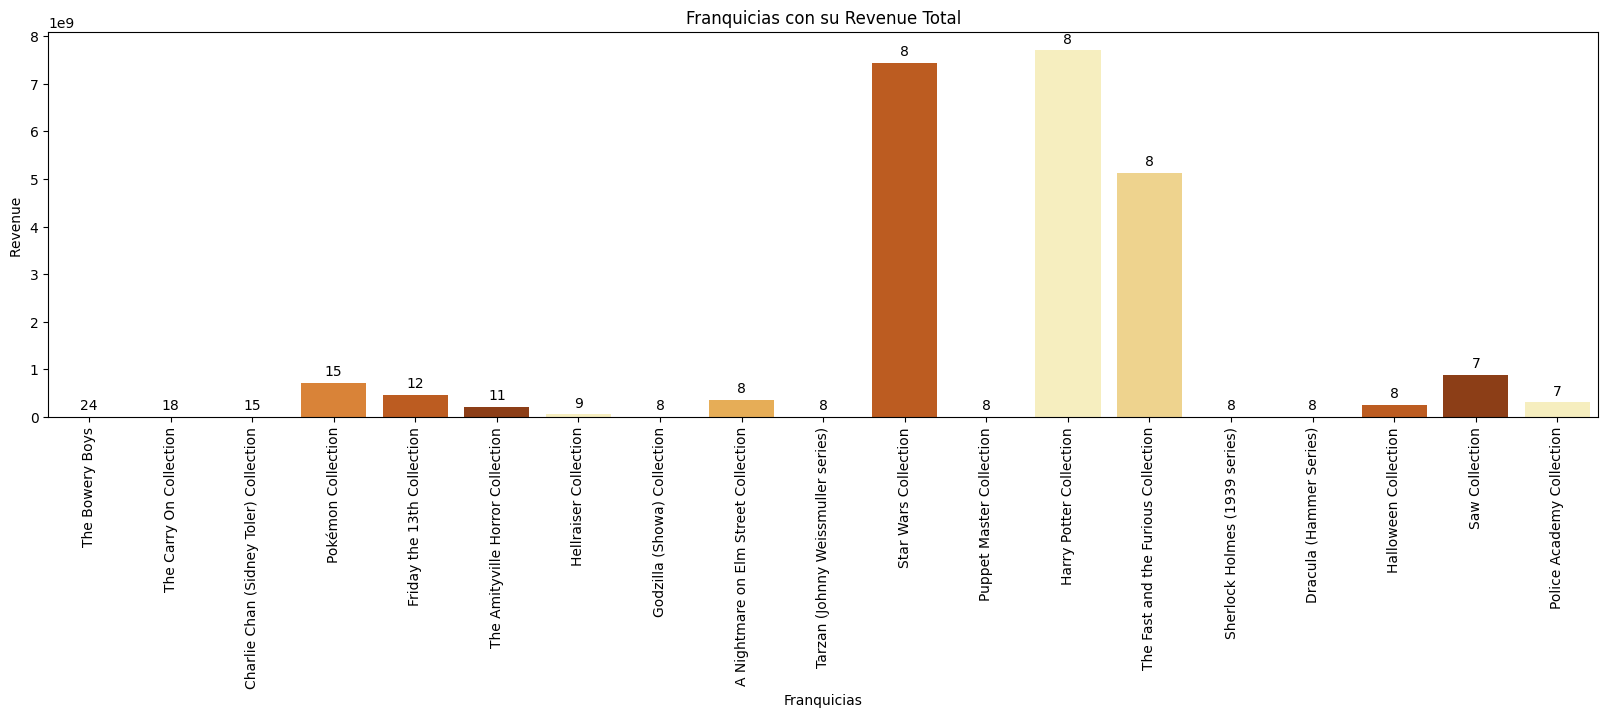

In [159]:
#Graficamos un Grafico de Barra sque muestre el Revenue por Franquicia con la cantidad de peliculas por cada una
plt.figure(figsize=(20,5))
ax = sns.barplot(y=mas_peli_franquicia[('revenue','sum')],x=mas_peli_franquicia.index,errorbar=None , palette = sns.color_palette("YlOrBr"))
plt.xlabel('Franquicias')
plt.title('Franquicias con su Revenue Total')
plt.ylabel('Revenue ')
plt.xticks(rotation=90)


count = mas_peli_franquicia[('title','count')]
ax.bar_label(ax.containers[0], labels=count, padding=3)

plt.show()

Se puede observar que las franquicias Harry Potter, Star Wars y Rapido y Furiosos son las que lideran en Revenue.

In [160]:
# function to get all uniqye categories(except NaN values) and return as a dictionary
def get_all_items(df , col):
    all_items = {}
    for row in df[col]:
        counter = 0
        if row == np.nan or isinstance(row,float) :
            continue
        for single_value in row:  
            value = all_items.get(single_value)
            if value == None:
                all_items[single_value] = counter + 1
            else:
                all_items[single_value] = value + 1
    return all_items

# get all genres
all_genres = get_all_items(df , 'genres')

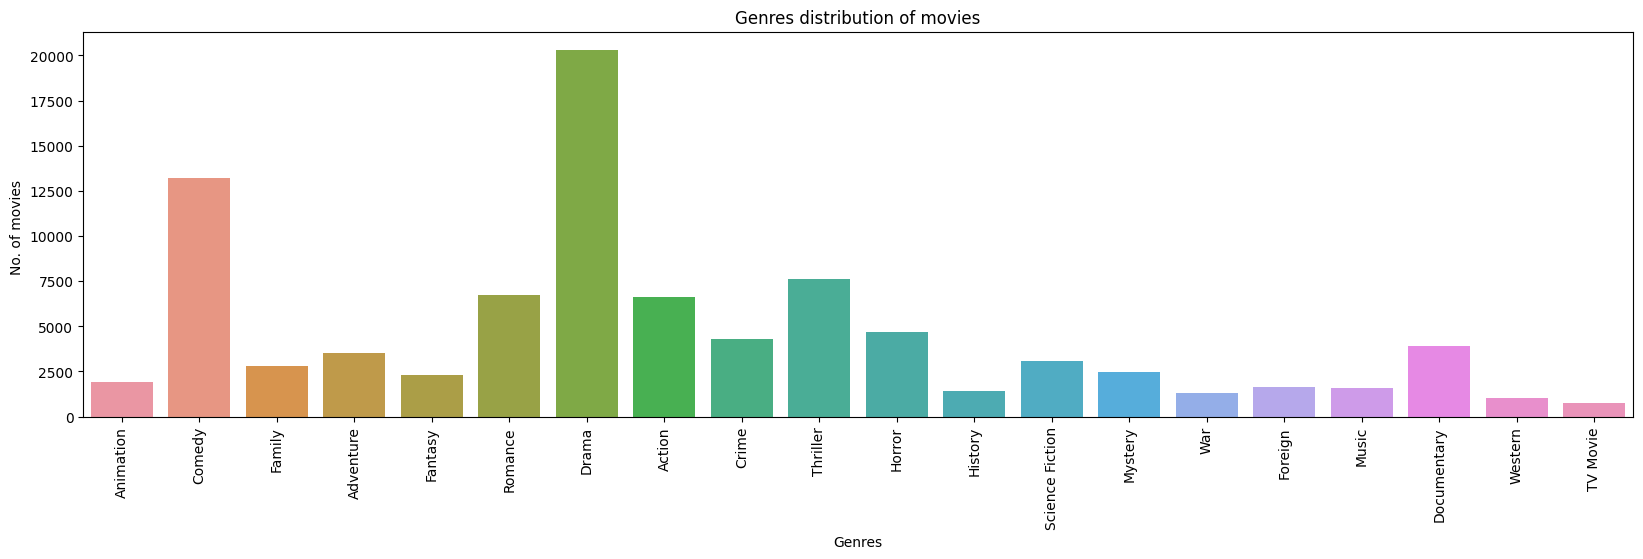

In [161]:
#graficamos
fig = plt.figure(figsize = (20, 5))
all_genre_keys = list(all_genres.keys())
all_genre_values = [int(i) for i in all_genres.values()]
sns.barplot(x=all_genre_keys, y = all_genre_values)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('No. of movies ')
plt.title('Genres distribution of movies')
plt.show()

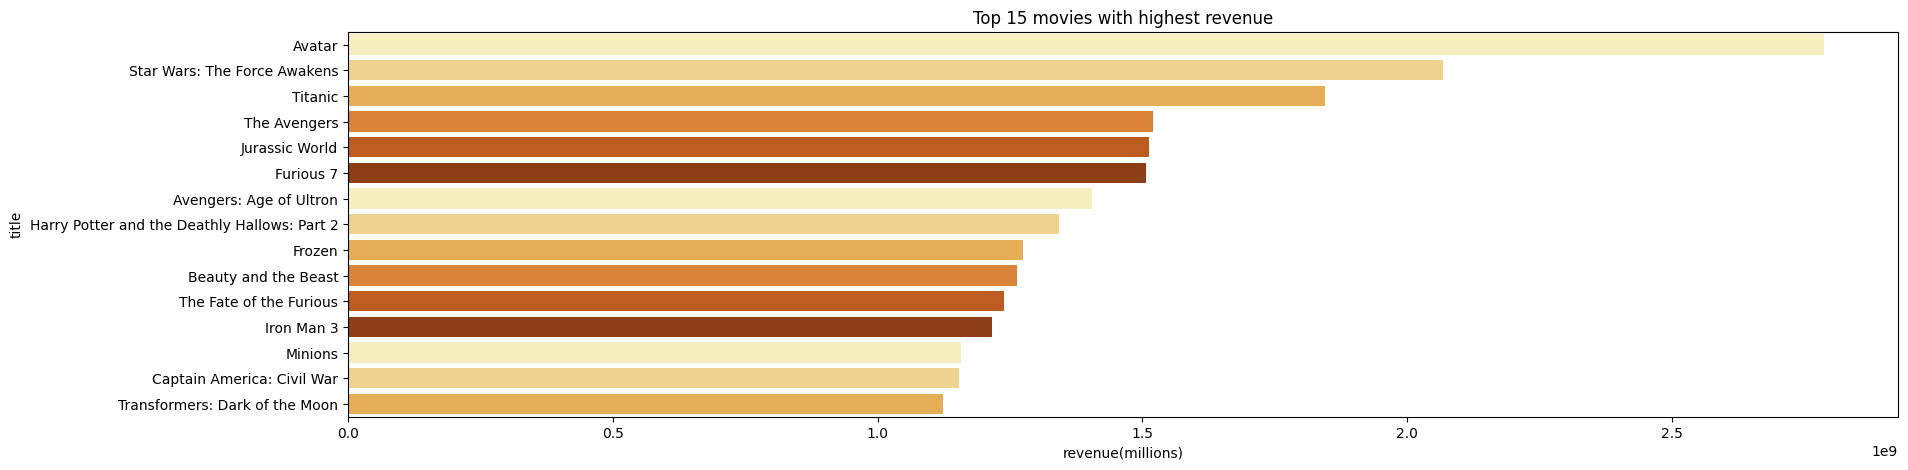

In [162]:
#Graficamos el top 15 de peliculas con mas Revenue
revenue_top_15 = df.sort_values(by='revenue',ascending=False)[0:15][['title','revenue','release_year']]

plt.figure(figsize=(20,5))
sns.barplot(y=revenue_top_15['title'],x=revenue_top_15['revenue'],errorbar=None , palette = sns.color_palette("YlOrBr"))
plt.xlabel('revenue(millions)')
plt.title('Top 15 movies with highest revenue')
plt.show()

Avatar, Star Wars y Titanic son las peliculas con mayor Revenue

In [163]:
#Obtenemos numero de peliculas por Actor
actors = get_all_items(df , 'cast')
actors = {k:v for (k,v) in actors.items() if v > 70}

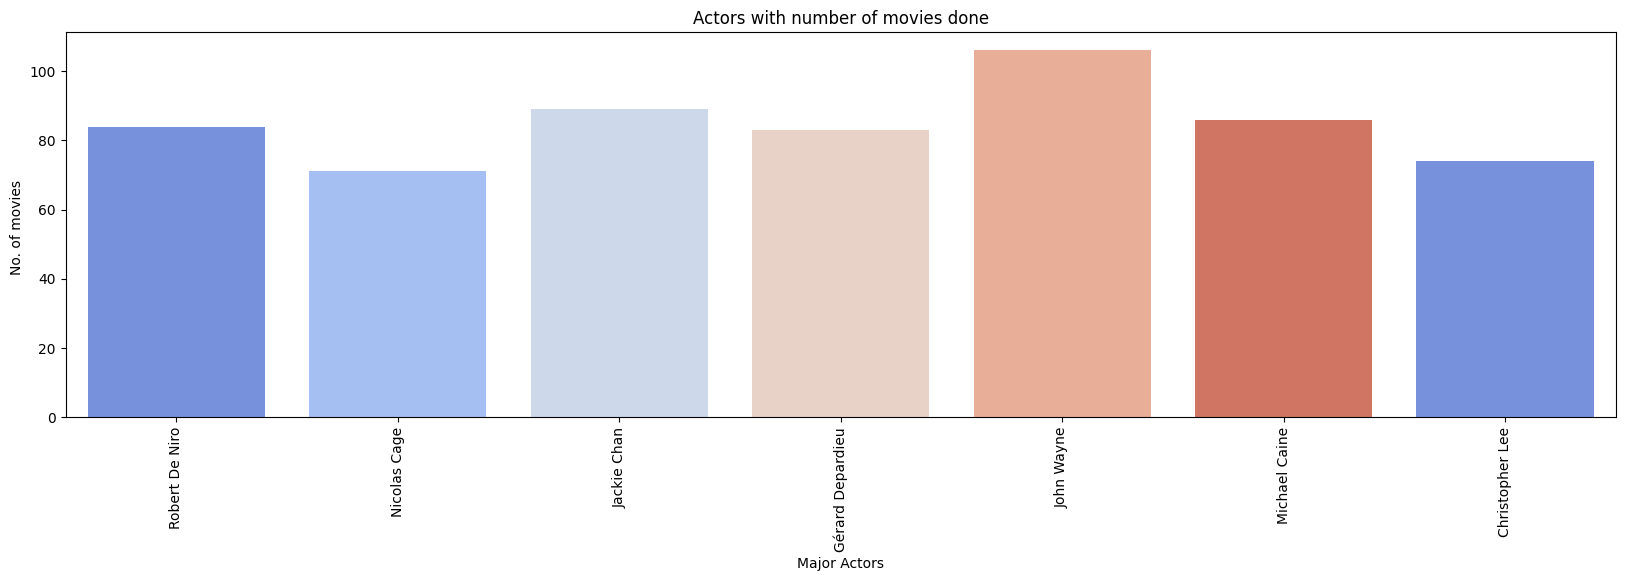

In [164]:
#Graficamos un grafico de barra que relacion Actores y Cantidad de Peliculas.
fig = plt.figure(figsize = (20, 5))
actor_keys = list(actors.keys())
actor_values = [int(i) for i in actors.values()]
sns.barplot(x=actor_keys, y = actor_values , palette = sns.color_palette("coolwarm"))
plt.xticks(rotation=90)
plt.xlabel('Major Actors')
plt.ylabel('No. of movies ')
plt.title('Actors with number of movies done')
plt.show()

John Wayne es el Actor con mas Peliculas del Dataset.

/var/folders/rl/4_3j3kb90d74wbdrz3mdbvn00000gn/T/ipykernel_82514/2405756879.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

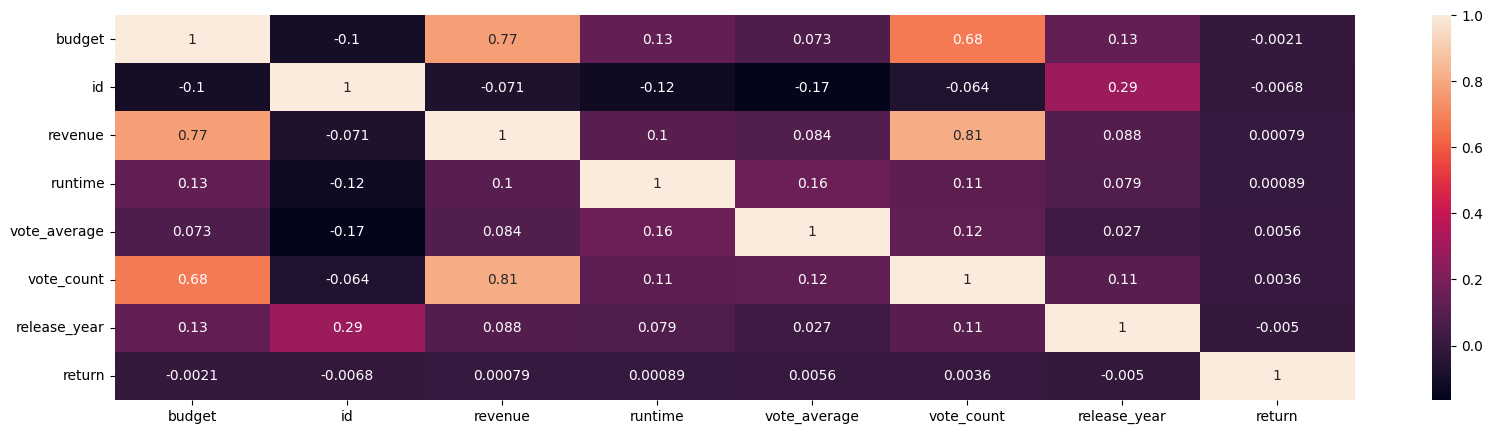

In [165]:
# Graficamos un mapa de Calor con la matriz de correlacion entre variables
plt.figure(figsize=(20,5))
sns.heatmap(df.corr(),annot=True)

Podemos observar en la matriz de correlacion que existe una alta correlacion positiva entre el budget de la pelicula y el revenue que obtiene.

De esta manera doy por finalizado mi EDA.